## ML

In [1]:
import re
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

!pip install category_encoders
import category_encoders as ce


In [125]:
'''importation du df'''
df = pd.read_csv(r'C:\Users\Qw\Desktop\projet_gaming\vgsales_complet.csv')



'''comparer les nom des jeux entre fichier de laurent et vg_sales (metacritic vs vg_sales)'''
samegame=[]
for i, j in zip(df['Name'],df['gamename']):
    if i in j or j in i:
        samegame.append(1)
    else:
        samegame.append(0)
df['same_game']=samegame 




'''recupération des données : '''
    # extraire les données de la colonne userscorewrap pour corriger les erreurs de
    #la colonne ratings et nb_votes
y=[]
for i in df['userscorewrap']:
    x = re.findall(r'[0-9\.0-9]+',i)
    y.append(x)
df['userscorewrap2']=y
    # remplacer les listes vides ou avec une seul valeur par [0,0] afin 
    # d'éviter l'erreur de "length..."
for i in df['userscorewrap2']:
    if i==[]:
        i.append(0)
        i.append(0)
    if len(i)==1:
        i.clear()
        i.append(0)
        i.append(0)
    # extraire les données de la colonne metascorewrap pour corriger les erreurs de
    #la colonne metascore et nb_critic
n=[]
for i in df['metascorewrap']:
    x = re.findall(r'[0-9\.0-9]+',i)
    n.append(x)
df['metascorewrap2']=n
    # remplacer les listes vides ou avec une seul valeur par [0,0] afin d'éviter l'erreur de "length..."
for i in df['metascorewrap2']:
    if i==[]:
        i.append(0)
        i.append(0)
    if len(i)==1:
        i.clear()
        i.append(0)
        i.append(0)
    # recuperer les données de la colonnes metascorewrap2 et userscorewrap2
x=[]
y=[]
for i in df['userscorewrap2']:
    x.append(i[0])
    y.append(i[1])
df['ratings']=x
df['nb_votes']=y

x=[]
y=[]
for i in df['metascorewrap2']:
    x.append(i[0])
    y.append(i[1])
df['metascore']=x
df['nb_critic']=y

    # recuperer série (si série donc =1 sinon 0)
serie=[]
def extract_series(x): 
    r = re.compile(r"Series:.*\n") 
    result=r.findall(x)
    if result!=[]:
        y=result[0]
        return(y[8:-2]) 
    else:
        return('0')
for i in df['description']:
    serie.append(extract_series(i))
df['serie']=serie
df['serie']=df['serie'].apply(lambda x: '1' if x!='0' else x)
df['serie']=df['serie'].astype(int)

    # recuperer Awards (si awards donc =1 sinon 0)
Awards=[]
def extract_awards(x): 
    r = re.compile(r"Awards:.*\n") 
    result=r.findall(x)
    if result!=[]:
        y=result[0]
        return(y[8:-1])                
    else:
        return('0')
for i in df['description']:
    Awards.append(extract_awards(i))
df['Awards']=Awards
df['Awards']=df['Awards'].apply(lambda x: '1' if x!='0' else x)
df['Awards']=df['Awards'].astype(int)

    # recuperer Like_Percent
Like_Percent =[]
def extract_percentage(x):
    r = re.compile(r"\n\d+% liked this video game")
    result=r.findall(x)
    if result!=[]:
        y=result[0] 
        return(y[1:3]) 
    else:
        return('0')
for i in df['description']:
    Like_Percent.append(extract_percentage(i))
df['Like_Percent']=Like_Percent
df['Like_Percent']=df['Like_Percent'].str.replace(r'%','').astype(int)
z=[]
for i in df['Like_Percent']:
    z.append(i/100)
df['Like_Percent']=z



'''supprimer les jeux non compatible avec vg_salles'''
df.drop(df[df['same_game']==0].index, inplace=True)



'''nettoyage : '''
    # remplacer les nan de la colonne year par 0 et la convertir en int
df['Year']=df['Year'].replace(np.nan, 0)
df['Year']=df['Year'].astype(int)
    # remplacer les nan de la colonne Publisher par not found
df['Publisher']=df['Publisher'].replace(np.nan, 'not found')
    # convertir les types des colonnes:
df['ratings']=df['ratings'].astype(float)
df['nb_votes']=df['nb_votes'].astype(int)
df['metascore']=df['metascore'].astype(int)
df['nb_critic']=df['nb_critic'].astype(int)


        
'''supprimer les colonnes dont on a plus besoin:'''
df.drop(['top','metascorewrap','userscorewrap','nbvotes','nbratings','description',
        'gamename','same_game','userscorewrap2','metascorewrap2','developper'], axis=1,
        inplace=True)



'''reorganisation df '''
df = df[['Rank', 'Name', 'Genre', 'Year','Publisher','Platform','NA_Sales',
      'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales','ratings','nb_votes', 'metascore'
         ,'nb_critic','serie','Like_Percent']] 


'''renomer les colonnes'''
df = df.rename(columns = {'ratings':'userNote','nb_votes':'userNbVote'
                          ,'metascore':'metaNote','nb_critic':'metaNbVote'})


# quantiles (1 = les jeux mauvais...)
df['metaNoteQ']=pd.cut(df['metaNote'], bins=[0,25,50,75,100], labels=[1,2,3,4])
df['metaNoteQ']=df['metaNoteQ'].fillna(1)
df['metaNoteQ']=df['metaNoteQ'].astype(int)


df.head()

,Rank,Name,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
0,1,Wii Sports,Sports,2006,Nintendo,Wii,41.49,29.02,3.77,8.46,82.74,8.1,453,76,51,1,0.96,4
1,2,Super Mario Bros.,Platform,1985,Nintendo,NES,29.08,3.58,6.81,0.77,40.24,8.5,98,84,14,1,0.92,4
2,3,Mario Kart Wii,Racing,2008,Nintendo,Wii,15.85,12.88,3.79,3.31,35.82,8.4,1047,82,73,0,0.96,4
3,4,Wii Sports Resort,Sports,2009,Nintendo,Wii,15.75,11.01,3.28,2.96,33.00,8.2,293,80,73,1,0.97,4
5,6,Tetris,Puzzle,1989,Nintendo,GB,23.20,2.26,4.22,0.58,30.26,8.2,258,83,27,0,0.00,4


In [126]:
new_df = df.drop(['Rank','Name','Global_Sales'],axis=1)
new_df.head()

,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
0,Sports,2006,Nintendo,Wii,41.49,29.02,3.77,8.46,8.1,453,76,51,1,0.96,4
1,Platform,1985,Nintendo,NES,29.08,3.58,6.81,0.77,8.5,98,84,14,1,0.92,4
2,Racing,2008,Nintendo,Wii,15.85,12.88,3.79,3.31,8.4,1047,82,73,0,0.96,4
3,Sports,2009,Nintendo,Wii,15.75,11.01,3.28,2.96,8.2,293,80,73,1,0.97,4
5,Puzzle,1989,Nintendo,GB,23.20,2.26,4.22,0.58,8.2,258,83,27,0,0.00,4


<AxesSubplot:>

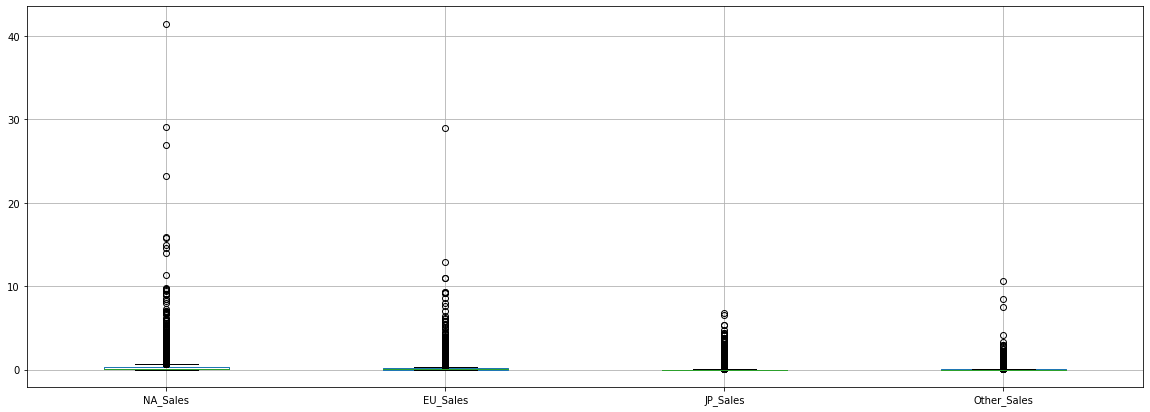

In [85]:
# les valeurs aberrantes new_df
new_df.boxplot(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], figsize=(20,7))

In [127]:
'''encoding la colonne Publisher'''
   #solution1: OrdinalEncoder ()
ord_enc = ce.OrdinalEncoder()
new_df[["Genre","Publisher", "Platform"]] = ord_enc.fit_transform(new_df[["Genre",
                                                                            "Publisher", 
                                                                            "Platform"]])
new_df
#new_df2['Genre_encod']=ord_enc.fit_transform(new_df2['Genre'])
#new_df2['Publisher_encod']=ord_enc.fit_transform(new_df2['Publisher'])
#new_df2['Platform_encod']=ord_enc.fit_transform(new_df2['Platform'])


   #solution2: TargetEncoder
#target_encoder = ce.TargetEncoder()
#new_df1['target_encoding'] = target_encoder.fit_transform(new_df1['Publisher'], new_df1['Global_Sales'])
#new_df

   #solution3: Label Encoding (pas recommandé pour les features par contre on peut l'utiliser pour 
#encoder la variable cible)
#new_df2['Publisher']= new_df2['Publisher'].astype('category')
#new_df2['target_encoding']= new_df2['Publisher'].cat.codes
#new_df2.head()



,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
0,1,2006,1,1,41.49,29.02,3.77,8.46,8.1,453,76,51,1,0.96,4
1,2,1985,1,2,29.08,3.58,6.81,0.77,8.5,98,84,14,1,0.92,4
2,3,2008,1,1,15.85,12.88,3.79,3.31,8.4,1047,82,73,0,0.96,4
3,1,2009,1,1,15.75,11.01,3.28,2.96,8.2,293,80,73,1,0.97,4
5,4,1989,1,3,23.20,2.26,4.22,0.58,8.2,258,83,27,0,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,11,2004,6,14,0.01,0.00,0.00,0.00,0.0,0,82,36,1,0.91,4
16592,7,2008,134,4,0.01,0.00,0.00,0.00,0.0,0,1,3,0,0.00,1
16594,6,2003,47,17,0.01,0.00,0.00,0.00,7.8,9,50,19,0,0.86,2
16595,3,2008,5,7,0.00,0.00,0.00,0.00,5.6,5,29,4,0,0.94,2


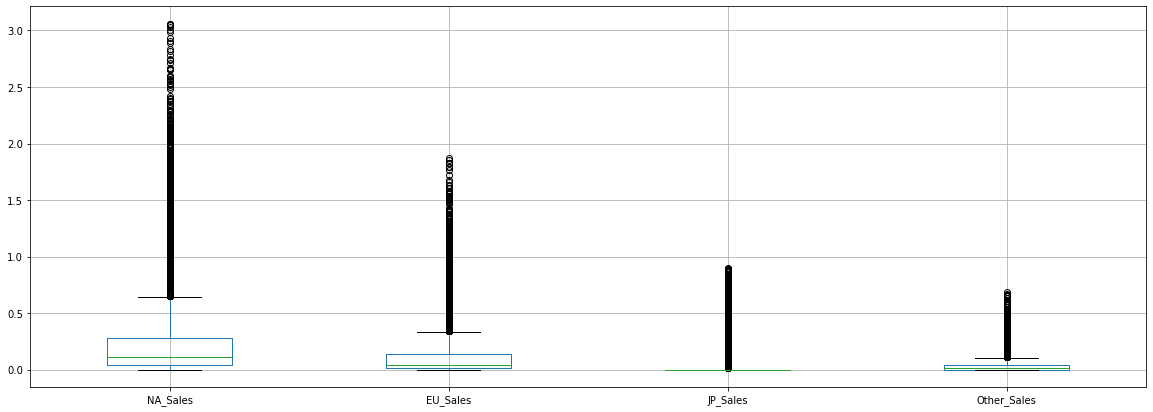

In [128]:
# supprimer les valeurs aberrantes en utilisant zscore
# définition zscore:
    # formule (x - la moyenne)/ecart-type de chaque colonne
# l'objectif :
    # est de standardiser le df afin de transformer les valeurs en une seule unité de mesure
    # et ensuite supprimer les valeurs aberrantes qui sont supérieur à 2 (<3)
    # car le zscore se situe entre -3 et 3.
from scipy import stats
new_df2=new_df[(np.abs(stats.zscore(new_df)) < 3).all(axis=1)]

# verification des valeures aberrantes new_df2
new_df2.boxplot(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], figsize=(20,7));

In [88]:
'''preprocessing'''
sc = StandardScaler().fit(new_df2)
new_df2[new_df2.columns]=pd.DataFrame(sc.transform(new_df2), index=new_df2.index)
new_df2

C:\Users\Qw\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
182,-1.212496,-0.699120,-0.681760,1.762372,7.227792,5.009867,7.562045,2.237406,1.027911,0.105127,1.281771,0.156093,1.133687,0.952254,1.110439
203,1.219173,1.413629,-0.681760,1.427779,6.312805,4.163365,7.276996,7.427889,1.027911,3.459936,1.214490,2.977006,-0.882078,0.952254,1.110439
206,0.003338,0.069153,-0.681760,-1.416260,7.577641,4.697998,2.431167,5.884772,0.475241,-0.207331,0.407113,0.644328,1.133687,0.690202,0.168643
212,0.611256,0.069153,-0.363380,-0.914371,7.120147,6.301897,-0.324304,5.884772,0.702811,0.095991,0.810801,0.101845,1.133687,-1.100490,1.110439
213,-0.908538,-1.851528,-0.681760,0.089408,7.173970,3.851496,8.132143,0.834573,0.897871,0.039347,1.079927,-0.386391,1.133687,0.974092,1.110439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,1.523131,-0.507052,-0.588119,0.758594,-0.630335,-0.559226,-0.324304,-0.568261,-1.865481,-0.302347,0.878083,0.752825,1.133687,0.886741,1.110439
16592,0.307297,0.261221,1.809092,-0.914371,-0.630335,-0.559226,-0.324304,-0.568261,-1.865481,-0.302347,-1.846813,-1.037371,-0.882078,-1.100490,-1.714947
16594,0.003338,-0.699120,0.179738,1.260483,-0.630335,-0.559226,-0.324304,-0.568261,0.670301,-0.285902,-0.198419,-0.169397,-0.882078,0.777553,-0.773152
16595,-0.908538,0.261221,-0.606847,-0.412481,-0.657246,-0.559226,-0.324304,-0.568261,-0.044920,-0.293211,-0.904874,-0.983122,-0.882078,0.952254,-0.773152


In [89]:
'''label + target'''
data_NA =new_df2.drop(['NA_Sales'],axis=1)
target_NA=new_df2['NA_Sales']

data_EU =new_df2.drop(['EU_Sales'],axis=1)
target_EU=new_df2['EU_Sales']

data_JP =new_df2.drop(['JP_Sales'],axis=1)
target_JP=new_df2['JP_Sales']

              valeur_estimee
intercept           0.001244
Genre              -0.003966
Year               -0.033366
Publisher          -0.010348
Platform            0.023175
EU_Sales            0.195010
JP_Sales            0.030299
Other_Sales         0.652644
userNote            0.002531
userNbVote          0.099835
metaNote            0.024194
metaNbVote         -0.011240
serie              -0.000018
Like_Percent       -0.007950
metaNoteQ          -0.016624 

le coeficient de determination sur train (R²) 0.6727686402144346
le coeficient de determination sur train (CV) 0.6687295149549126
le coeficient de determination sur test (R²) 0.6688186487880728
le coeficient de determination sur test (CV) 0.6577811355202956


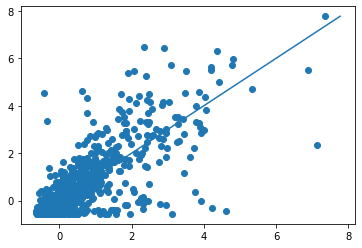

In [90]:
'''modele linear Regression ==> data_EU'''

# Train + test
X_train, X_test, y_train, y_test=train_test_split(data_EU,target_EU, test_size=0.2)

# Linear Regrassion
lr = LinearRegression()
lr.fit(X_train, y_train)

# intercept_ et coef_ (ax+b)
coef=list(lr.coef_)
coef.insert(0,lr.intercept_)
feat=list(data_NA.columns)
feat.insert(0,'intercept')
print(pd.DataFrame({'valeur_estimee':coef}, index=feat),'\n')

#performance train
print('le coeficient de determination sur train (R²)', lr.score(X_train,y_train))
print('le coeficient de determination sur train (CV)', cross_val_score(lr,X_train,y_train).mean())
print('le coeficient de determination sur test (R²)', lr.score(X_test,y_test))
print('le coeficient de determination sur test (CV)', cross_val_score(lr,X_test,y_test).mean())

#predict
pred_test = lr.predict(X_test)
plt.scatter(pred_test, y_test);
plt.plot((y_test.min(),y_test.max()),(y_test.min(),y_test.max()));


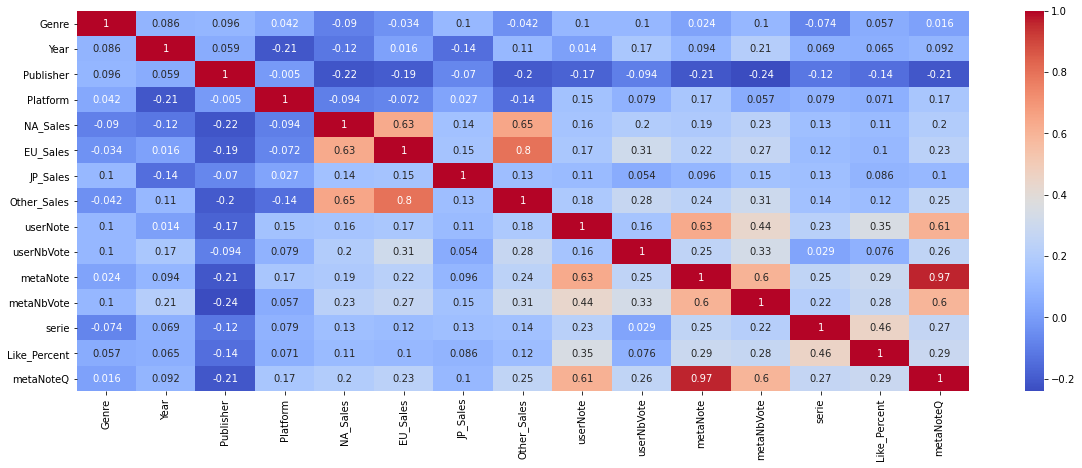

In [42]:
plt.figure(figsize=(20,7))
sns.heatmap(new_df2.corr(),annot=True,cmap='coolwarm');

In [162]:
'''Regression logistique ==> target (EU_Sales)'''
#importer la libraire
from sklearn.linear_model import LogisticRegression

#creation d'un nv df pour le modele R.Log
new_df_RLg = new_df

# arrondire les targets avant preprocessing
eu=[]
for i in new_df_RLg['EU_Sales']:
    eu.append(int(i//1))
new_df_RLg['EU_Sales']=eu

"""na=[]
for i in new_df_RLg['NA_Sales']:
    na.append(int(i//1))
new_df_RLg['NA_Sales']=na

jp=[]
for i in new_df_RLg['JP_Sales']:
    jp.append(int(i//1))
new_df_RLg['JP_Sales']=jp

os=[]
for i in new_df_RLg['Other_Sales']:
    os.append(int(i//1))
new_df_RLg['Other_Sales']=os"""

# data + target 
data_EU =new_df_RLg.drop(['EU_Sales'],axis=1)
target_EU=new_df_RLg['EU_Sales']

# train + test
X_train, X_test, y_train, y_test=train_test_split(data_EU,target_EU, test_size=0.2)

# creation clf
clf = LogisticRegression(C=1.0)

# entrainer le modele
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# calcul de la performance
    # la matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
    # taux de bonne prédiction
clf.score(X_test,y_test)

C:\Users\Qw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9566724436741768

In [161]:
'''Regression logistique ==> target(metaNoteQ) '''
#importer la libraire
from sklearn.linear_model import LogisticRegression
#creation d'un nv df pour le modele R.Log
new_df_RLg = new_df

# data + target 
data =new_df_RLg.drop(['metaNoteQ'],axis=1)
target=new_df_RLg['metaNoteQ']

# train + test
X_train, X_test, y_train, y_test=train_test_split(data,target, test_size=0.2)

# creation clf
clf = LogisticRegression(C=1.0)

# entrainer le modele
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# calcul de la performance
    # matrice de confusion
print('* matrice de confusion:','\n',pd.crosstab(y_test, y_pred, rownames=['classe reelle'], colnames=['classe predict']),'\n')
    # taux de bonne prédiction
print('* taux de bonne prédiction:', clf.score(X_test,y_test),'\n')
    # le rapport de classification 
from sklearn.metrics import classification_report
print('* le rapport de classification:','\n',classification_report(y_test,y_pred))

* matrice de confusion: 
 classe predict    1    2    3    4
classe reelle                     
1               432   18    8    1
2                17  106   64    8
3                 0    0  911   47
4                 0    0   51  645 

* taux de bonne prédiction: 0.9072790294627383 

* le rapport de classification: 
               precision    recall  f1-score   support

           1       0.96      0.94      0.95       459
           2       0.85      0.54      0.66       195
           3       0.88      0.95      0.91       958
           4       0.92      0.93      0.92       696

    accuracy                           0.91      2308
   macro avg       0.90      0.84      0.86      2308
weighted avg       0.91      0.91      0.90      2308



C:\Users\Qw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# tester l'arbre de décision
